<a href="https://colab.research.google.com/github/yukti845/Dog-breed-identification-project/blob/master/Deep_Learning_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlowHub

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a pjoto of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities  for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


## 4. Features

Some information about the data:
* We're dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs(this means there are 120 different classes)
* There are around 10,000 images in the training set.
* There are around 10,000 images in the test set.


In [22]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


### Get our workspace ready

* Import TensorFlow
* Import TensorFlow Hub
* Make sure we're using a GPU
 

In [24]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF hub version: ", hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version:  2.2.0
TF hub version:  0.8.0
GPU available


## Getting our data ready (tuning into tensors)

With all m,achine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations)

Let's start by checking our data and checking out the labels.

In [25]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dataset Data Science/dog-breed-identification/labels.csv")

In [26]:
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     d793a68896bf50ec6b19adbf2770b450  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [27]:
print(labels_csv.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


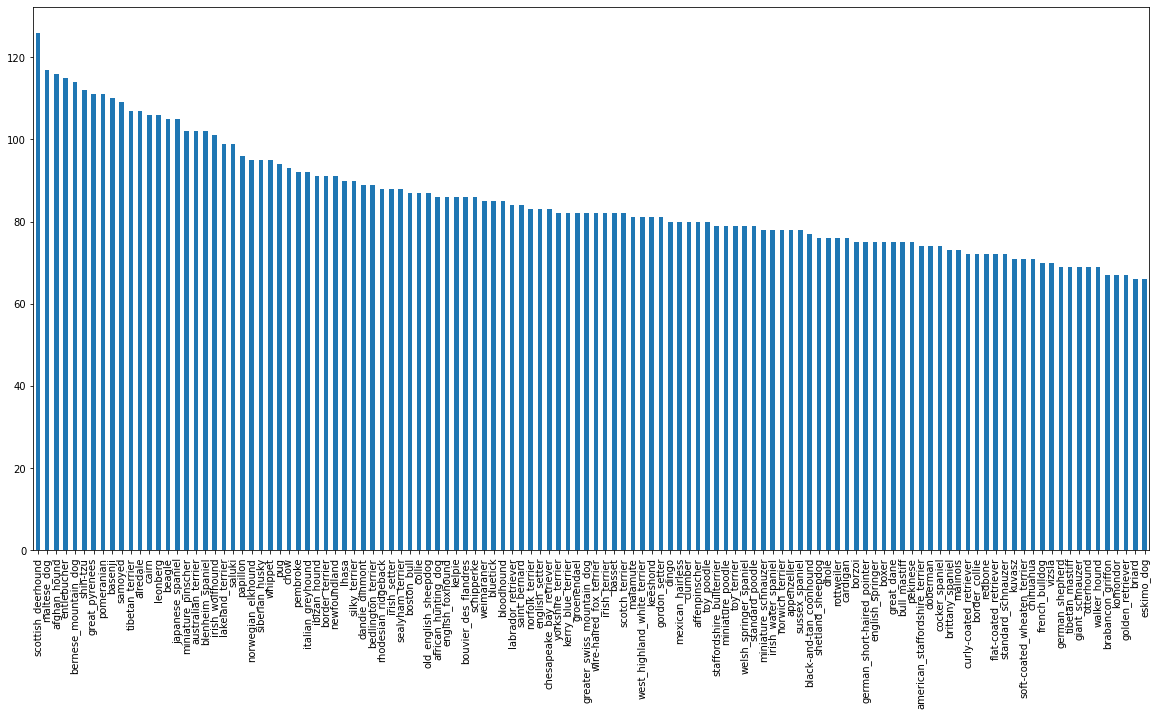

In [28]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [29]:
labels_csv["breed"].value_counts().median()

82.0

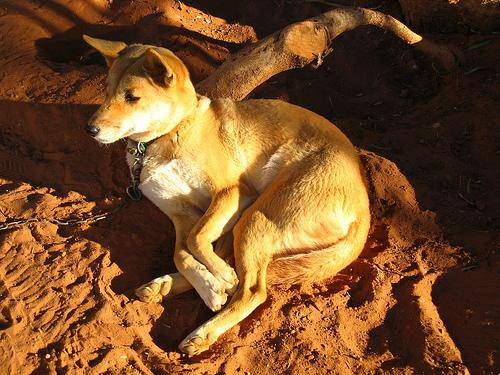

In [30]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dataset Data Science/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

In [31]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [32]:
# Create pathnames from image ID's
filename = ["drive/My Drive/Dataset Data Science/dog-breed-identification/train/"+fname+".jpg" for fname in labels_csv["id"]]

filename[:10]

['drive/My Drive/Dataset Data Science/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dataset Data Science/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dataset Data Science/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dataset Data Science/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dataset Data Science/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dataset Data Science/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dataset Data Science/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dataset Data Science/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dataset Data Science/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dataset Dat

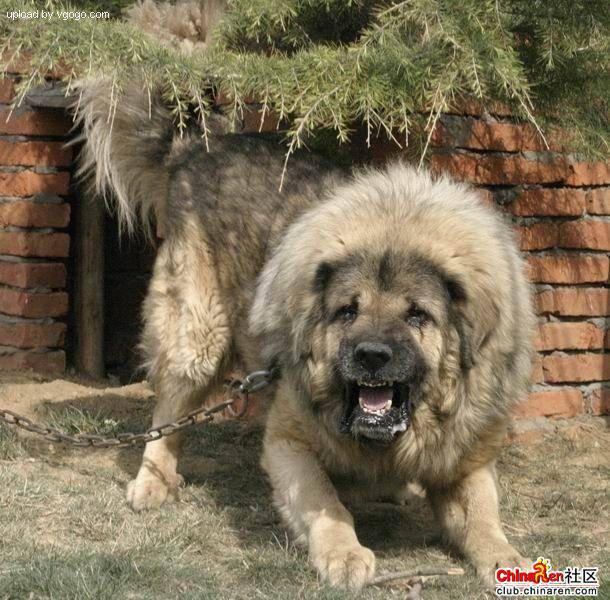

In [33]:
Image(filename[9000])

In [34]:
labels_csv["breed"][9000]

'tibetan_mastiff'

 Let's prepare our labels

In [35]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [36]:
len(labels)

10222

In [37]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [38]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [39]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [40]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0]))  #index where label occurs
print(boolean_labels[0].argmax())  # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

In [41]:
# Setup x and y variables
x = filename
y = boolean_labels

We're going to start off experimenting with 1000 images and increase as needed

In [43]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [45]:
# Let's spilt our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation sets of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                    y[:NUM_IMAGES],
                                                    test_size=0.2,
                                                    random_state=42)

len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

## Perprocessing images (turning images into Tensors)

To preprocess our images into Tensors, we're going to write a function which does a few things:
1. Take an image filepath as input.
2. Use Tensorflow to read the file and save it to a variable 'image'.
3. Turn our 'image' (a jpg) into Tensors.
4. Resize the 'image' to be a shape of (224, 224).
5. Return the modified 'image'.

In [46]:
# Convert an image into numpy array
from matplotlib.pyplot import imread
image = imread(filename[42])
image.shape

(257, 350, 3)

In [48]:
image.max(), image.min()

(255, 0)

In [49]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>